# <div style="color:orange;">[Projet] Prêt à dépenser - Application</div>

<img src="img/pad_logo.png" width="150">

# <div style="color:blue" id="ch0">Sommaire</div>

1. [Imports, fonctions et input](#ch1)<br>

2. [Décision et explication](#ch2)<br>

# <div id="ch1" style="color: blue">1. Imports, fonctions et input</div>

#### Imports et fonctions

In [1]:
import re
import gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [2]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
def restore_model(file_name):
    model = joblib.load(f"mod/{file_name}.plk')
    features = joblib.load(f"mod/{file_name}_features.plk")
    return model, features

In [4]:
class ShapObject:
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

In [5]:
def get_shap_object(frame, idx):
    shap_object = ShapObject(base_values=explainer.expected_value,
                             values=explainer.shap_values(frame)[idx,:],
                             feature_names=features,
                             data=frame[idx,:])
    return shap_object

In [39]:
def decision_report(data, ids):
    decision = ['Accordé !', 'Refusé !']
    lg = len(data)
    for idx in range(lg):
        print()
        print('===============================')
        print(f"Prêt n°{ids[idx]} ==> {decision[int(model.predict(data[[idx]])[0])]}")
        print('===============================')
        print()
        print(f"Probabilités prédites par le modèle pour chaque classe :")
        print('------------------------------------------------------')
        proba = model.predict_proba(data[[idx]])
        labels = ['Crédit remboursé (0)', 'Crédit défaut (1)']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(proba, cmap=plt.cm.Greens)
        for i in range(0, 2):
            text = ax.text(i, 0, round(proba[0][i], 3), ha="center", va="center", color="orange")
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        plt.show()
        print()
        print(f"Influence des variables sur la décision -> Diagramme en cascade :")
        print('---------------------------------------------------------------')
        shap.waterfall_plot(get_shap_object(data, idx), max_display=15)

#### Récupération de l'input

<div class="alert alert-block alert-warning">

Cette étape déclenche une erreur si le fichier `application_input.csv` est absent ou s'il ne contient aucune donnée.

Comme un client peut contracter un prêt sans en avoir eu un auparavant, les autres tables ne doivent pas obligatoirement être présentes.
    
</div>

In [7]:
app = pd.read_csv('csv/application_input.csv')
if len(app) == 0:
    raise ValueError('Aucune donnée dans le fichier "application_input.csv"')
try:
    bur = pd.read_csv('csv/bureau_input.csv')
except FileNotFoundError:
    bur = pd.DataFrame()
try:
    bur_bal = pd.read_csv('csv/bureau_balance_input.csv')
except FileNotFoundError:
    bur_bal = pd.DataFrame()
try:
    pos = pd.read_csv('csv/POS_CASH_balance_input.csv')
except FileNotFoundError:
    pos = pd.DataFrame()
try:
    cc_bal = pd.read_csv('csv/credit_card_balance_input.csv')
except FileNotFoundError:
    cc_bal = pd.DataFrame()
try:
    prev = pd.read_csv('csv/previous_application_input.csv')
except FileNotFoundError:
    prev = pd.DataFrame()
try:
    ins = pd.read_csv('csv/installments_payments_input.csv')
except FileNotFoundError:
    ins = pd.DataFrame()

#### Transformation et consolidation des données

In [8]:
# Preprocessing Application_train_input
app = app[app['CODE_GENDER'] != 'XNA']
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    app[bin_feature], uniques = pd.factorize(app[bin_feature])
app, cat_cols = one_hot_encoder(app)
app['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
app['DAYS_EMPLOYED_PERC'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
app['INCOME_CREDIT_PERC'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT']
app['INCOME_PER_PERSON'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']
app['ANNUITY_INCOME_PERC'] = app['AMT_ANNUITY'] / app['AMT_INCOME_TOTAL']
app['PAYMENT_RATE'] = app['AMT_ANNUITY'] / app['AMT_CREDIT']

In [9]:
# Preprocessing Bureau_input & Bureau_balance_input
if (len(bur_bal) > 0) & (len(bur) > 0):
    bur_bal, bur_bal_cat = one_hot_encoder(bur_bal)
    bur, bur_cat = one_hot_encoder(bur)
    bur_bal_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bur_bal_cat:
        bur_bal_aggregations[col] = ['mean']
    bur_bal_agg = bur_bal.groupby('SK_ID_BUREAU').agg(bur_bal_aggregations)
    bur_bal_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bur_bal_agg.columns.tolist()])
    bur = bur.join(bur_bal_agg, how='left', on='SK_ID_BUREAU')
    bur.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bur_bal, bur_bal_agg
    gc.collect()

if len(bur) > 0:
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in bur_cat: cat_aggregations[cat] = ['mean']
    for cat in bur_bal_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bur_agg = bur.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bur_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bur_agg.columns.tolist()])
    active = bur[bur['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bur_agg = bur_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    closed = bur[bur['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bur_agg = bur_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bur
    gc.collect()
    app = app.join(bur_agg, how='left', on='SK_ID_CURR')
    del bur_agg
    gc.collect()

In [10]:
# Preprocessing Previous_applications_input
if len(prev) > 0:
    prev, cat_cols = one_hot_encoder(prev)
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    app = app.join(prev_agg, how='left', on='SK_ID_CURR')
    del prev_agg
    gc.collect()

In [11]:
# Preprocessing POS_CASH_balance_input
if len(pos) > 0:
    pos, cat_cols = one_hot_encoder(pos)
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    app = app.join(pos_agg, how='left', on='SK_ID_CURR')
    del pos_agg
    gc.collect()

In [12]:
# Preprocessing Installments_payments_input
if len(ins) > 0:
    ins, cat_cols = one_hot_encoder(ins)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    app = app.join(ins_agg, how='left', on='SK_ID_CURR')
    del ins_agg
    gc.collect()

In [13]:
# Preprocessing Credit_card_balance_input
if len(cc_bal) > 0:
    cc_bal, cat_cols = one_hot_encoder(cc_bal)
    cc_bal.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc_bal.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    cc_agg['CC_COUNT'] = cc_bal.groupby('SK_ID_CURR').size()
    del cc_bal
    gc.collect()
    app = app.join(cc_agg, how='left', on='SK_ID_CURR')
    del cc_agg
    gc.collect()

In [14]:
app_input = app.copy()
app_input.to_csv('input.csv', index=False)

In [15]:
app_columns = app.columns
app.replace(to_replace=np.inf, value=np.nan, inplace=True)

In [16]:
simple = SimpleImputer(strategy='constant', fill_value=0)
app = simple.fit_transform(app)
scaler = StandardScaler()
app = scaler.fit_transform(app)
app.shape

(11, 599)

# <div id="ch2" style="color: blue">2. Décision et explication</div>

#### Alignement des colonnes du jeu de données

In [17]:
model, features = restore_model('log_S')
build = pd.DataFrame(data=app, columns=app_columns)
build = build.drop('TARGET', axis=1)
to_add = []
for f in features:
    if f not in app_columns:
        build[f] = 0
build.shape

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

(11, 809)

#### Décision

In [18]:
shap.initjs()

In [19]:
#explainer = shap.TreeExplainer(model)
explainer = shap.LinearExplainer(model, masker=shap.maskers.Impute(build))
shap_values = explainer.shap_values(build)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


Prêt n°100002 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


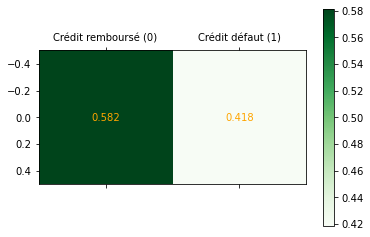


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


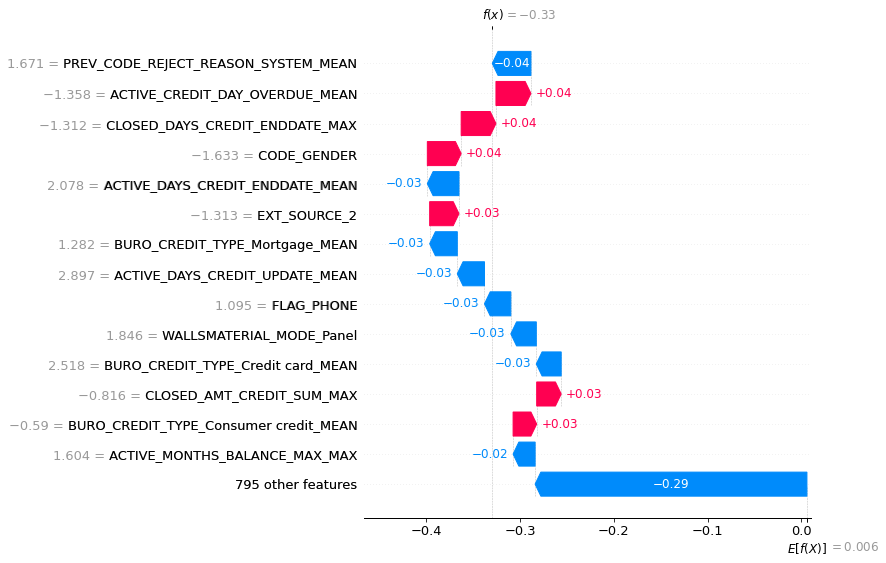


Prêt n°100003 ==> Refusé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


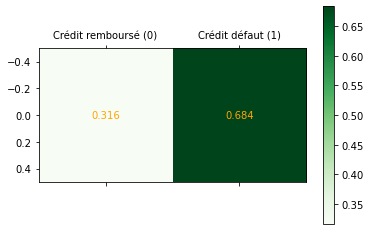


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


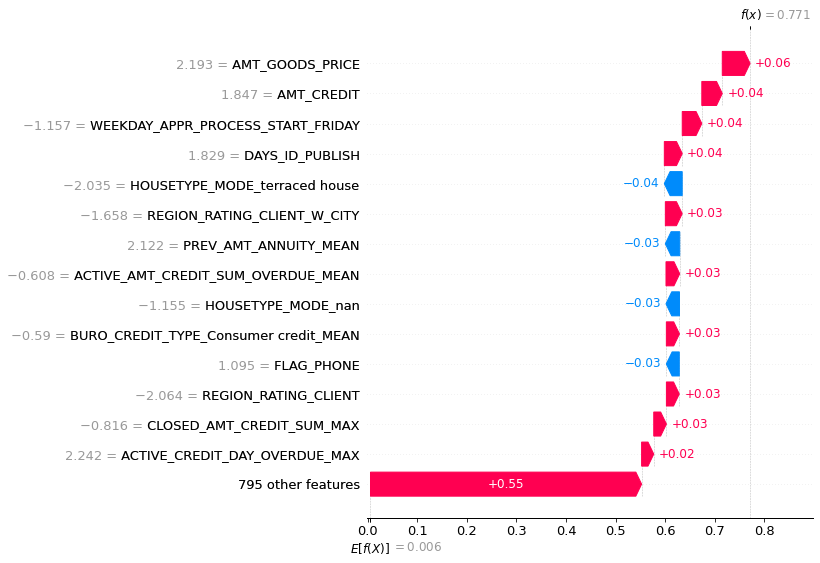


Prêt n°100006 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


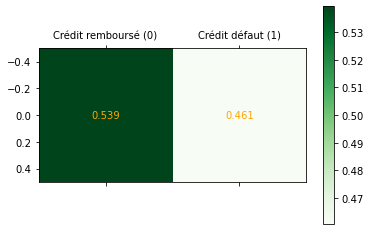


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


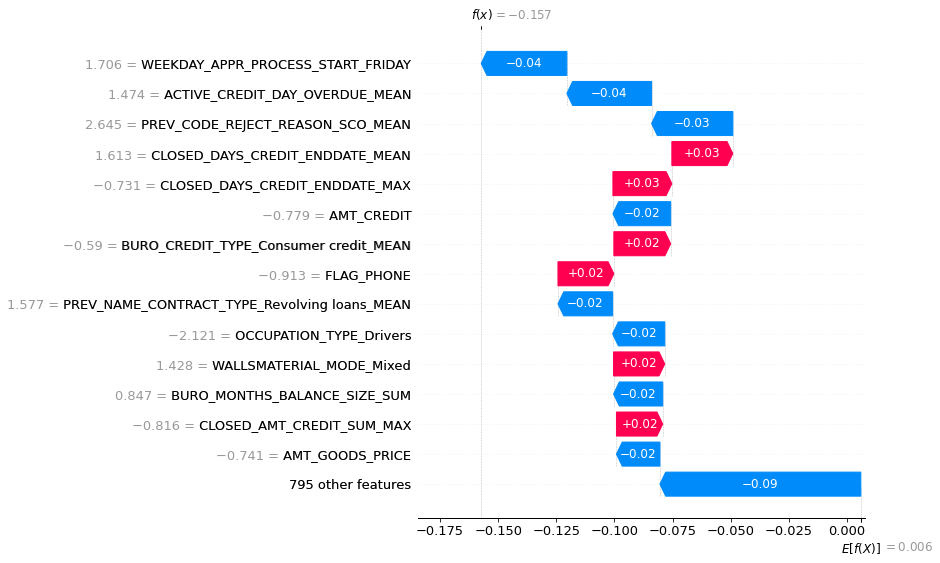


Prêt n°100018 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


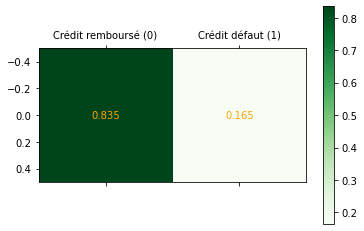


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


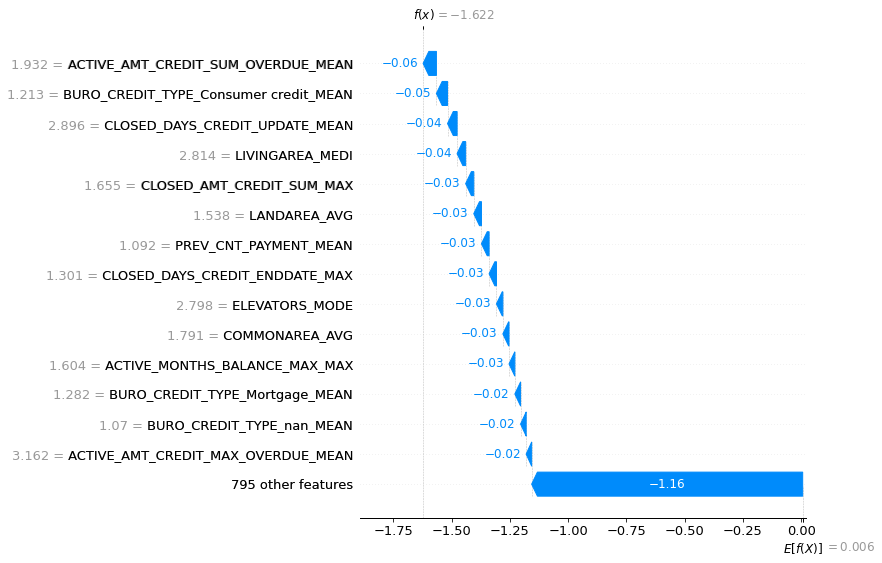


Prêt n°100024 ==> Refusé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


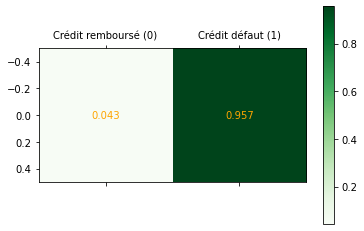


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


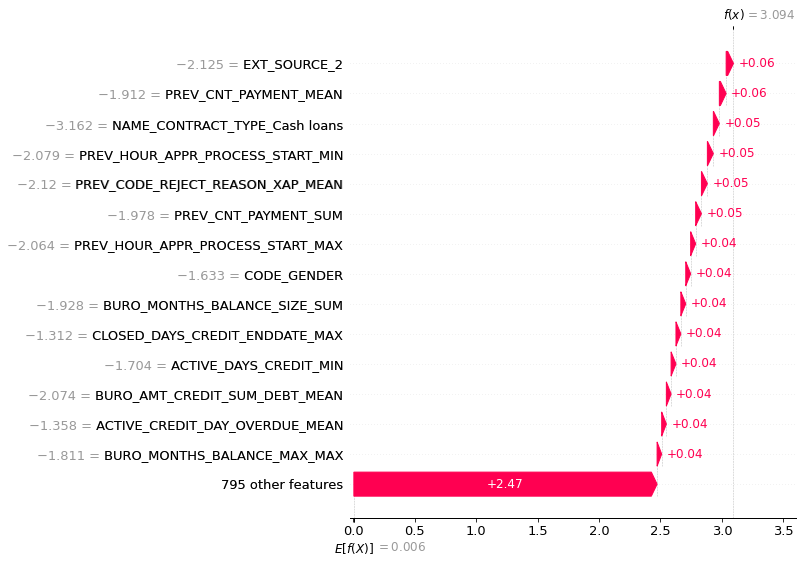


Prêt n°100026 ==> Refusé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


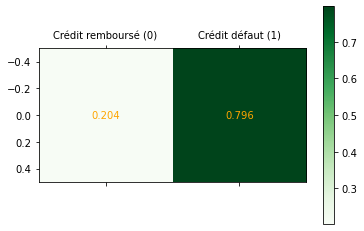


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


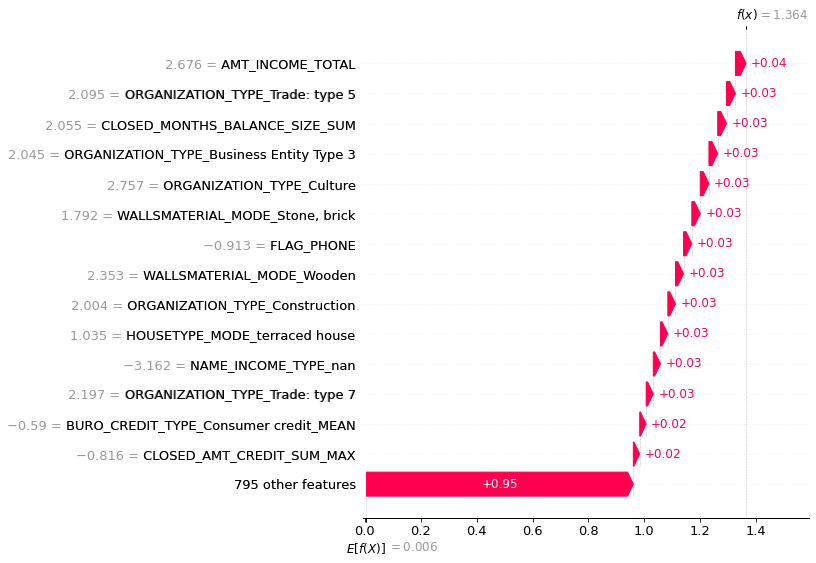


Prêt n°100027 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


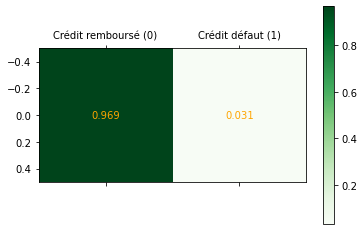


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


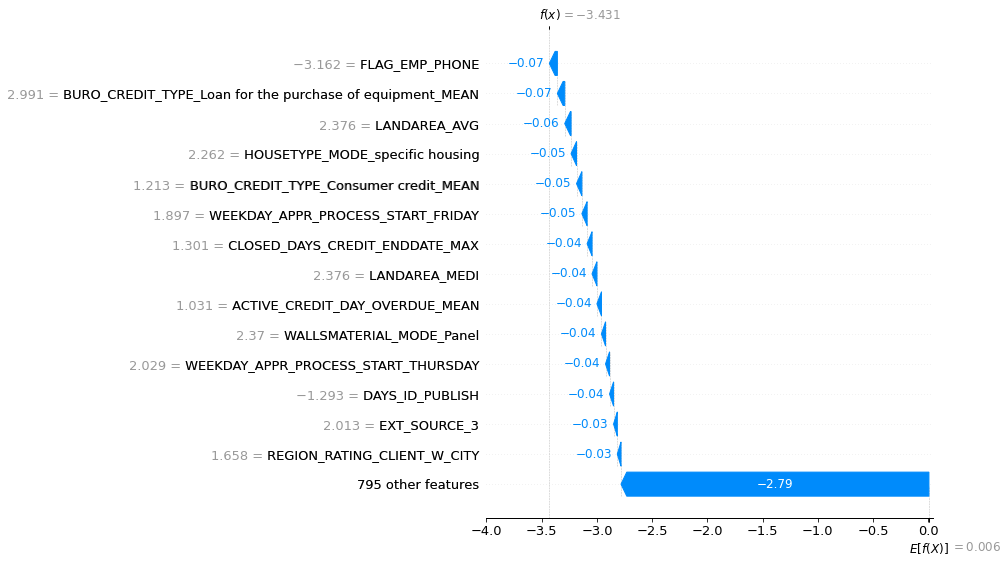


Prêt n°100030 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


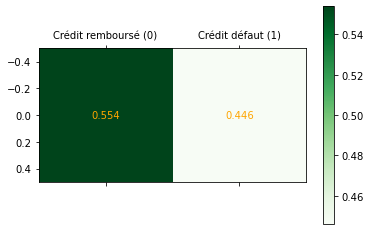


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


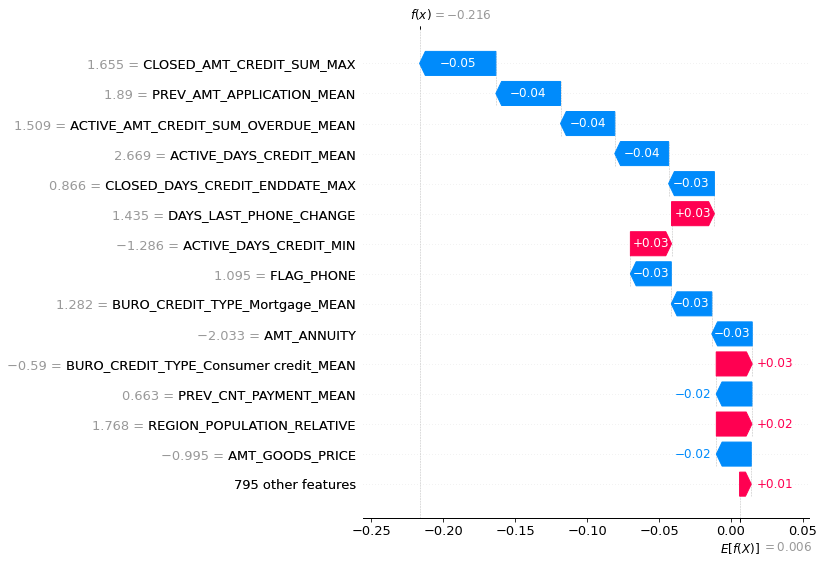


Prêt n°100031 ==> Refusé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


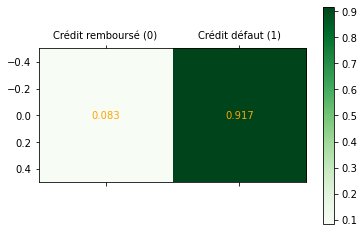


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


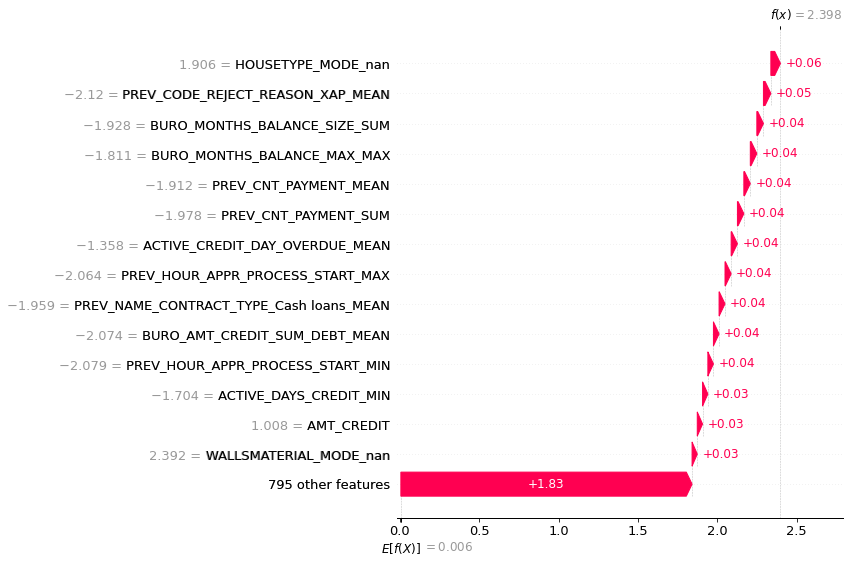


Prêt n°100047 ==> Refusé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


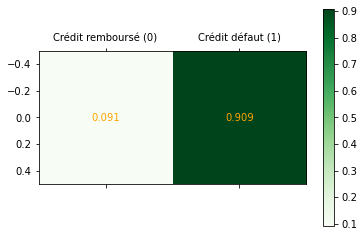


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


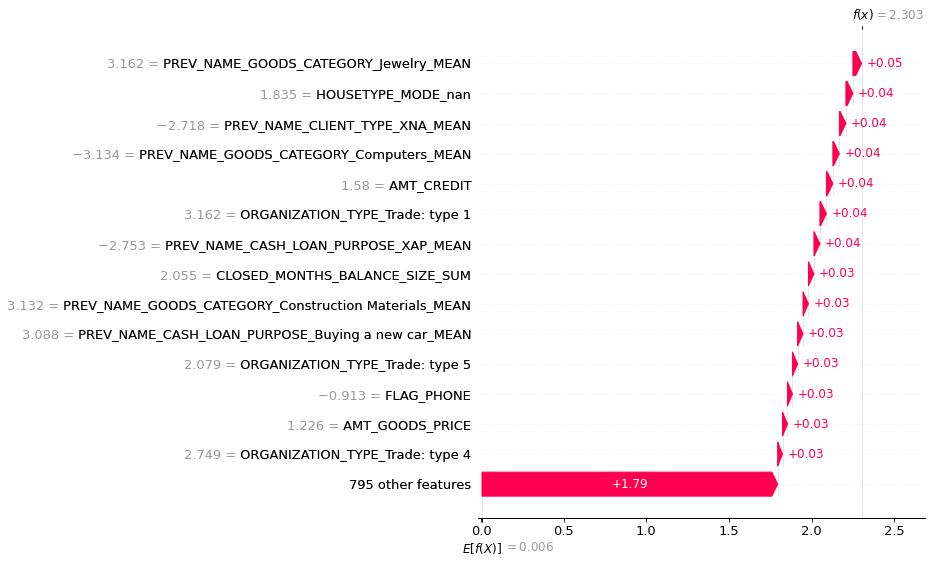


Prêt n°100049 ==> Accordé !

Probabilités prédites par le modèle pour chaque classe :
------------------------------------------------------


FixedFormatter should only be used together with FixedLocator


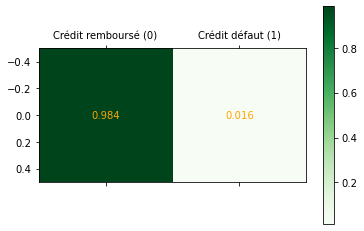


Influence des variables sur la décision -> Diagramme en cascade :
---------------------------------------------------------------


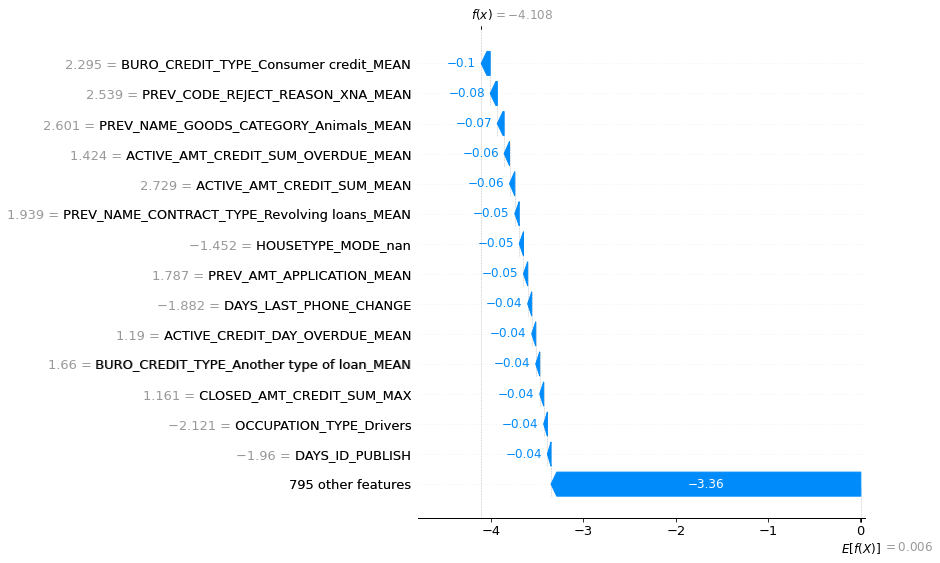

In [40]:
decision_report(build.values, app_input['SK_ID_CURR'])

[*(Retour sommaire)*](#ch0)